2019 Tennis Tournaments
-- 

**Introduction**

For this project, our group wanted to answer the question: How does a tennis player's age, number of aces, and serve points relate to the number of matches they won in tournaments held in 2019?

For background, an ace is when a player performs a legal serve (a shot to start the point) that is not touched by the opponent's racquet. Note that this differs from a serve point, which just describes any point scored off of a serve (regardless of whether the ball was touched by the opponent's racquet or not).

In order to answer our group's predictive question, we work with a dataset containing various statistics of the top 500 tennis players worldwide. These stats were pulled from tournaments worldwide during the 2019 season. The dataset itself is highly detailed, with information ranging from the surface the match was played on, to whether the player is left or right handed. Due to the scale of the complete dataset, we have narrowed down the dataset to just the player's age, aces, and serve points.

**Methods and Results**

In [1]:
#Load required libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)
library(ISLR)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#Load the 2019 tennis match data from the web
# for this analysis we will only be using the names, age, serve points of each player
# since the actual number of wins for a player is not in this data set use winner_name
atp <- read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv") |>
    select(winner_name, winner_age, w_ace, w_svpt)
head(atp)

Rows: 2806 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): tourney_id, tourney_name, surface, tourney_level, winner_entry, wi...
dbl (35): draw_size, tourney_date, match_num, winner_id, winner_seed, winner...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


winner_name,winner_age,w_ace,w_svpt
<chr>,<dbl>,<dbl>,<dbl>
Kei Nishikori,29.0,3,77
Daniil Medvedev,22.8,10,52
Kei Nishikori,29.0,2,47
Jo-Wilfried Tsonga,33.7,12,68
Daniil Medvedev,22.8,12,105
Jeremy Chardy,31.8,10,94


In [3]:
# We want each row of the data frame to have the winner's name, and a column for thier aces, serve points, wins
# and average ages.

# Create a data frame with the total aces and serve points for each player
atp_points <- atp |>
    group_by(winner_name) |>
    summarize(aces = sum(w_ace), serve_points = sum(w_svpt))

# Create a vector with the number of wins for each player
# This is done by counting the number of times a player's name appears in the winner_name column
atp_wins <- atp |>
    group_by(winner_name) |>
    summarize(wins = n()) |>
    pull(wins)

# Create a vector with the average age of each player. Since the age variable in this dataset has many
# decimal places we take the average age of a player over the year and remove all decimals.
atp_age <- atp |>
    group_by(winner_name) |>
    summarize(age = mean(winner_age)) |>
    mutate(age = round(age, 0)) |>
    pull(age)

#Combine into one data frame and remove winner_name column since it is no longer needed
atp_data <- bind_cols(atp_points, wins = atp_wins) |>
    bind_cols(age = atp_age) |>
    select(-winner_name)
head(atp_data)

aces,serve_points,wins,age
<dbl>,<dbl>,<int>,<dbl>
153,1907,27,31
7,97,1,33
NA,NA,1,21
85,2029,30,31
9,216,3,20
1,55,1,30


In [4]:
#Split the data into testing and training sets.
set.seed(1)

atp_split <- initial_split(atp_data, prop = 0.75, strata = wins)
atp_training <- training(atp_split)
atp_testing <- testing(atp_split)

In [5]:
#Construct a table for the number of observations / missing values for each variable
atp_missing <- count(atp_training, name = "observations") |>
    mutate(na_vals = sum(is.na(atp_training)))
atp_missing

observations,na_vals
<int>,<int>
181,120


Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”


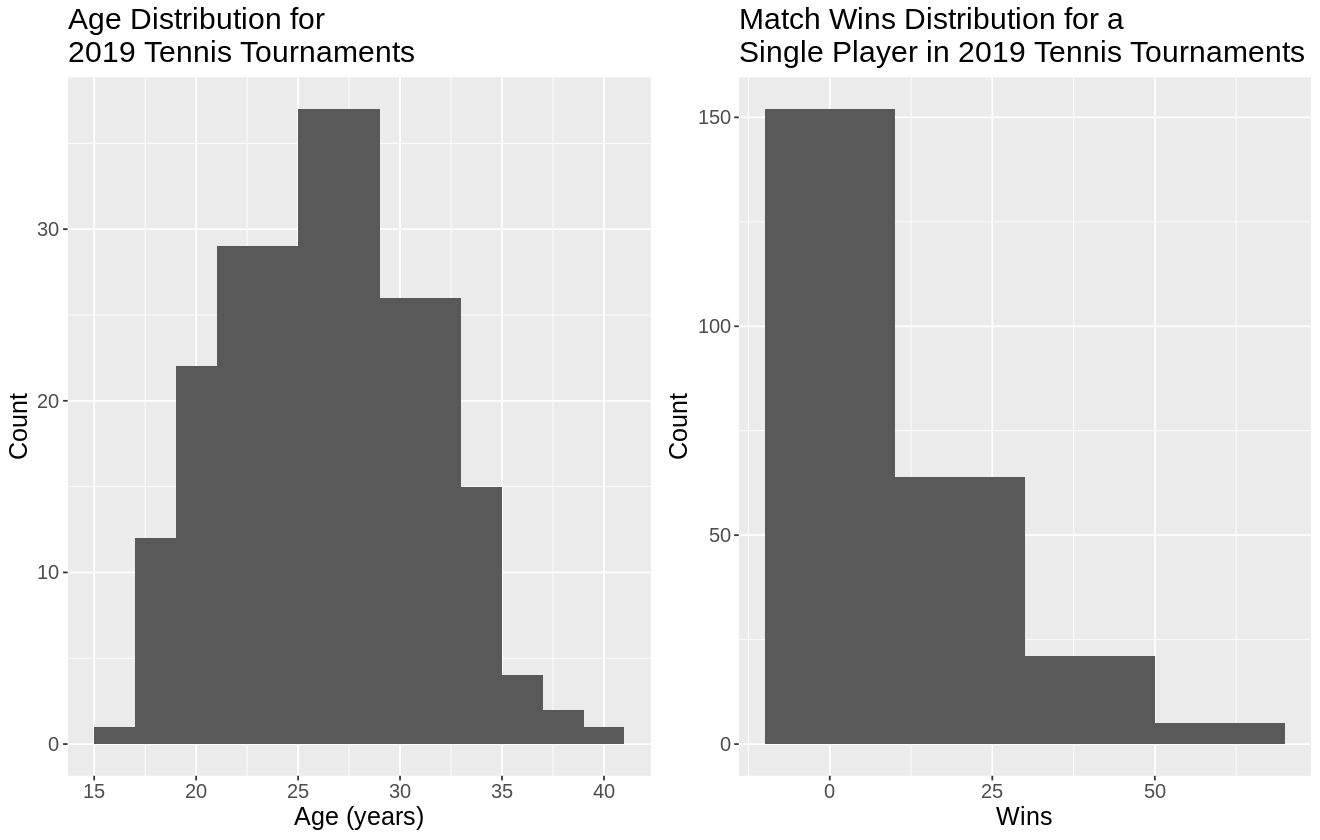

In [17]:
#Age and match wins distribution visualization (for entire dataset)
options(repr.plot.height = 7, repr.plot.width = 11)

age_hist <- ggplot(atp_data, aes(x = age)) +
    geom_histogram(binwidth = 2) +
    labs(x = "Age (years)", y = "Count",
         title = "Age Distribution for \n2019 Tennis Tournaments") +
    theme(text = element_text(size = 15))

win_hist <- ggplot(atp_data, aes(x = wins)) +
    geom_histogram(binwidth = 20) +
    labs(x = "Wins", y = "Count",
     title = "Match Wins Distribution for a \nSingle Player in 2019 Tennis Tournaments") +
    theme(text = element_text(size = 15))

plot_grid(age_hist, win_hist, ncol = 2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


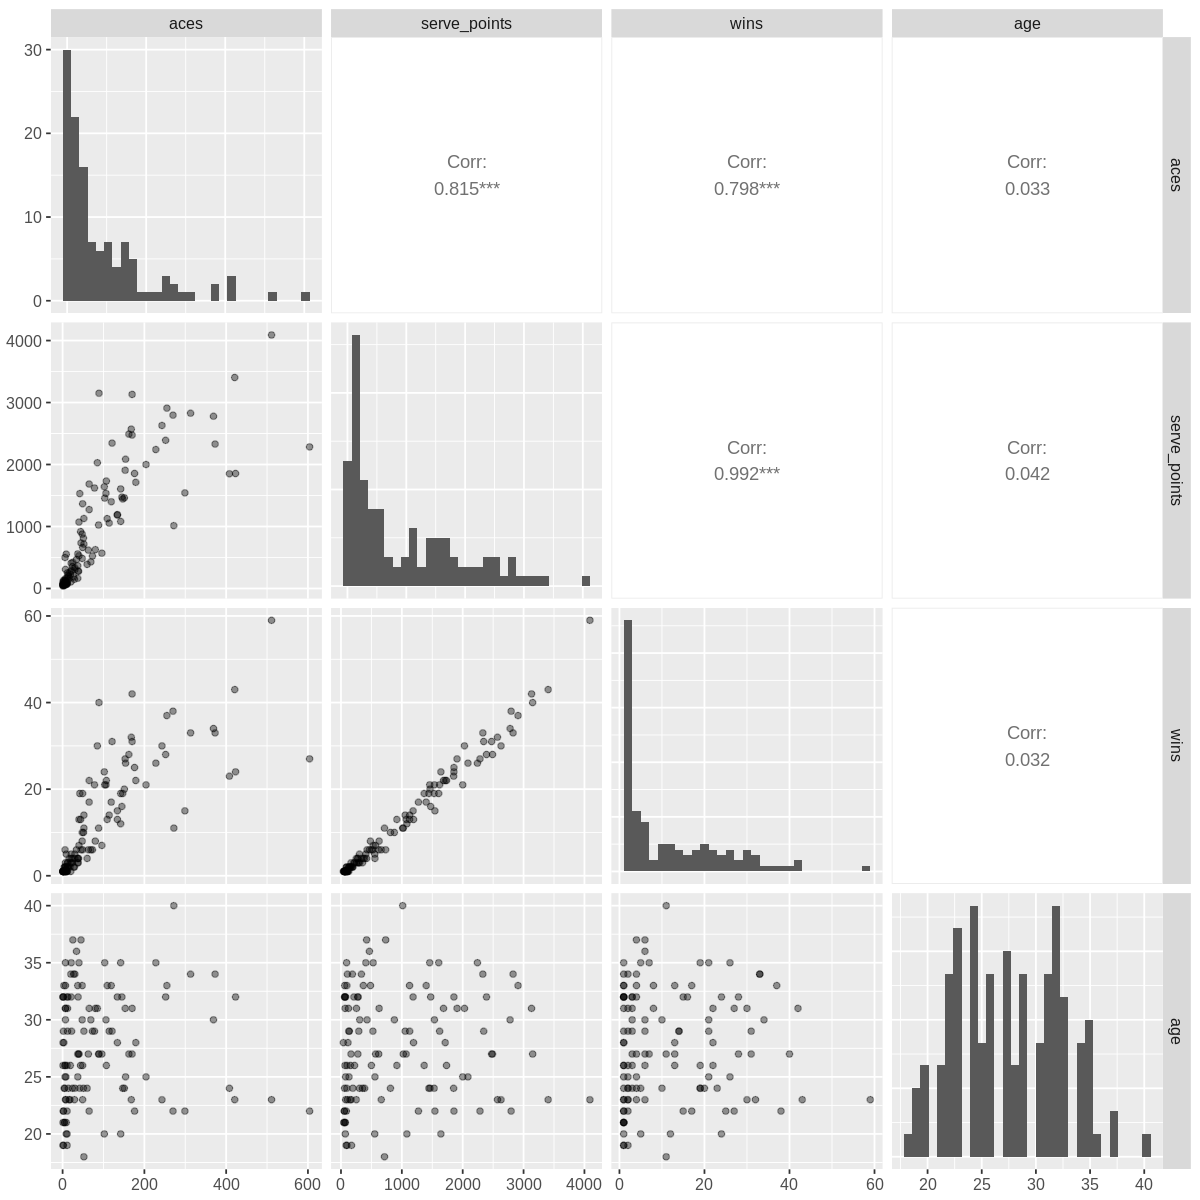

In [7]:
#Display the relationships between all variables
options(repr.plot.width = 10, repr.plot.height = 10)

atp_matrix <- atp_training |> 
    na.omit() |> # remove na values
    ggpairs(lower = list(continuous = wrap('points', alpha = 0.4)),
            diag = list(continuous = "barDiag")) +
    theme(text = element_text(size = 12))
atp_matrix

In [8]:
# Define specification for linear regression model 
atp_lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

In [9]:
# Define formula for model
atp_lm_recipe <- recipe(wins ~ aces + serve_points + age, data = atp_training)

In [10]:
# Fit the linear regression model
atp_lm_fit <- workflow() |> 
    add_recipe(atp_lm_recipe) |>
    add_model(atp_lm_spec) |>
    fit(atp_training)
atp_lm_fit 

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)          aces  serve_points           age  
    0.438595     -0.003186      0.013139     -0.025216  


In [11]:
# Predict on training data
atp_preds <- atp_lm_fit |>
    predict(atp_training) |>
    bind_cols(atp_training) |>
    rename(predicted_wins = .pred)

Warning message:
“Removed 60 rows containing missing values or values outside the scale range
(`geom_point()`).”


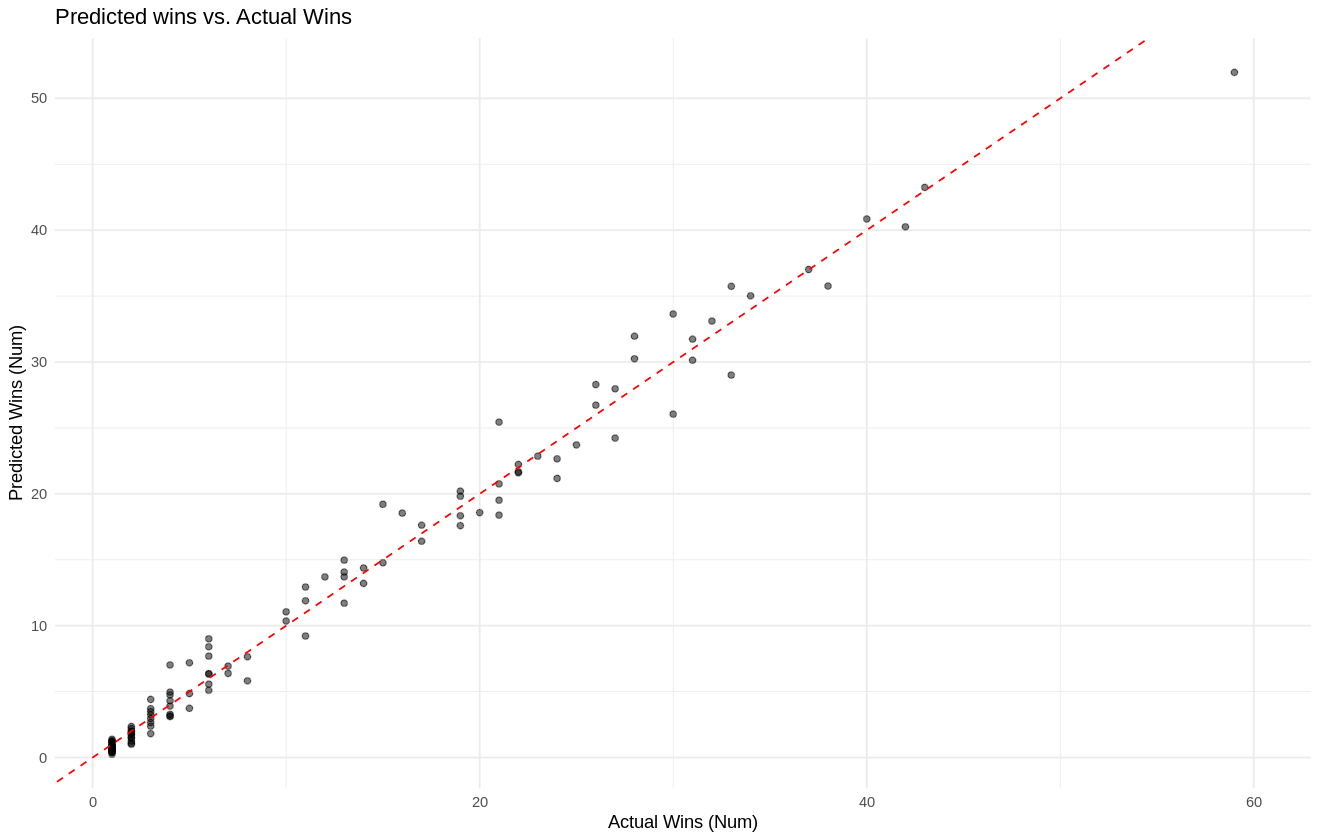

In [18]:
# Actual vs Predicted Wins Visualization
wins_comparsion_plot <- ggplot(atp_preds, aes(x = wins, y = predicted_wins)) + 
                        geom_point(alpha = 0.5) +
                        geom_abline(slope = 1, intercept = 0, col = "red", linetype = "dashed") +
                        labs(x = "Actual Wins (Num)", y = "Predicted Wins (Num)",
                        title = "Predicted wins vs. Actual Wins") + 
                        theme(text = element_text(size = 20)) +
                        theme_minimal()
wins_comparsion_plot

In [13]:
# Metrics for test data
atp_test_results <- atp_lm_fit |>
    predict(atp_testing) |>
    bind_cols(atp_testing) |>
    metrics(truth = wins, estimate = .pred)
atp_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.6045759
rsq,standard,0.9859255
mae,standard,1.0826597


In [14]:
# RMSE for the test data predictions
atp_rmse <- atp_test_results |>
    filter(.metric == "rmse") |>
    pull()
atp_rmse

[1] 1.604576

In [19]:
# Results for test data
atp_test_preds <- atp_lm_fit |>
    predict(atp_testing) |>
    bind_cols(atp_testing) |>
    na.omit()
head(atp_test_preds)

.pred,aces,serve_points,wins,age
<dbl>,<dbl>,<dbl>,<int>,<dbl>
2.7436863,9,216,3,20
0.4015776,1,55,1,30
4.1324600,37,340,3,26
11.5191180,96,928,11,32
6.4372946,14,506,5,24
31.0183367,208,2420,27,22


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


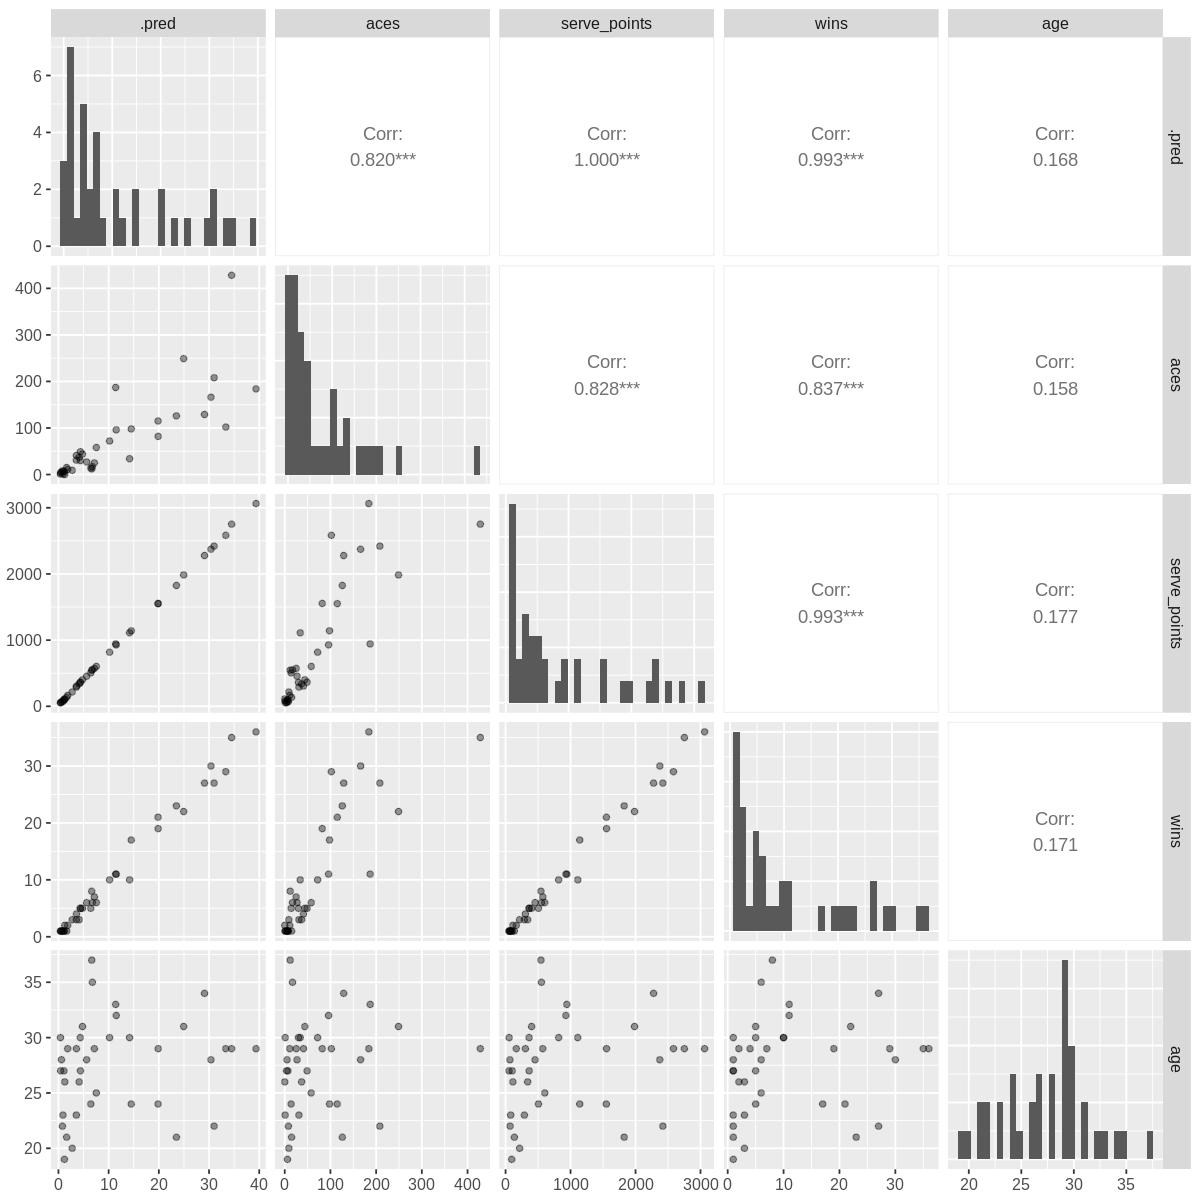

In [16]:
# Visualation of relationships between predicted wins (.pred), and other 
options(repr.plot.width = 10, repr.plot.height = 10)

atp_test_matrix <- atp_test_preds |> 
    ggpairs(lower = list(continuous = wrap('points', alpha = 0.4)),
            diag = list(continuous = "barDiag")) +
    theme(text = element_text(size = 12))
atp_test_matrix

**Discussion**

Summary:

The analysis we have done aimed to investigate how age, number of aces, and serve points relate to the number of matches won by tennis players in the 2019 tournaments. The regression model, constructed using these variables, revealed a significant statistical relationship between age and wins. Age had a negative coefficient, indicating that an increase in age was associated with fewer wins and that positive coefficients for aces and serve points suggest that a greater number of these is correlated with an increase in match wins. 

Comparison to Expectations: 

The regression model aligns with our initial experiences that aces and serve points would correlate positively with match wins. This is also supported by evidence from Cui et al. (2018) who says female tennis players in grand slams won more first and second serve points, as well as more aces on average.

However, the inverse relationship between age and match wins suggests a potential peak performance age, after which a player's performance may degrade, coinciding with findings by Aku & Yang (2023) who suggest a decline in sports performance with age among Chinese junior men's tennis players. It was anticipated that experience might correlate with performance, but the findings prompt that physical prime may have a greater impact. 

Impact: 

The importance of studies has implications for coaching and player development. Trainers of professional tennis players may focus on enhancing service games for players, as indicated by the positive correlation between aces, serve points, and match wins. Considering the age factor, it might be crucial for a player's team to tailor training and recovery strategies to extend the peak performance window of players. Furthermore, using this analysis could influence tournament prediction methods and the betting market as it provides a way to estimate a player's chance of winning based on their service game strength and age.


Future Questions:

- How does the relationship between age, aces, serve points and wins vary across different levels of tournament play (e.g., Grand Slans vs. Association of Tennis Professionals [ATP] 250)?
- What other variables might affect the number of wins, such as mental toughness or recovery rate?
- How does this relationship change over a certain player's career, and can we predict when that player will reach their peak performance?

These questions and current analysis can bring a better understanding of tennis dynamics and can be valuable for a broad range of individuals invested in this sport and seeking to improve it as our study serves as a stepping stone for succeeding research about this topic.


**References**

Aku, Y., & Yang, C. B. (2023). The relative age effect among Chinese junior men's tennis players and its impact on sports performance. PloS one, 18(10), e0292443. https://doi.org/10.1371/journal.pone.0292443

Cui, Y., Gómez, M. Á., Gonçalves, B., & Sampaio, J. (2018). Performance profiles of professional female tennis players in grand slams. PloS one, 13(7), e0200591. https://doi.org/10.1371/journal.pone.0200591

Sackmann, J. (2024). atp_matches_2019. tennis_atp. https://github.com/JeffSackmann/tennis_atp